Using device: cuda
dat shape (neurons x trials): (39209, 5900)

=== Running PCA pipeline ===
PCA: 15 components explain ≥90% variance.


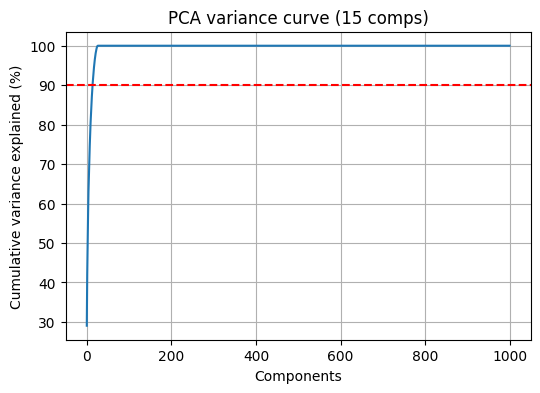

PCA: computed Kendall Tau for 500 neurons

=== Training SAE on PCA features (monosemantic expansion) ===
Epoch  10/60 | loss=0.000948
Epoch  20/60 | loss=0.001288
Epoch  30/60 | loss=0.000709
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000559
Epoch  60/60 | loss=0.000550
SAE latent shapes: train (4500, 100), test (1400, 100)
SAE: computed Kendall Tau for 500 neurons


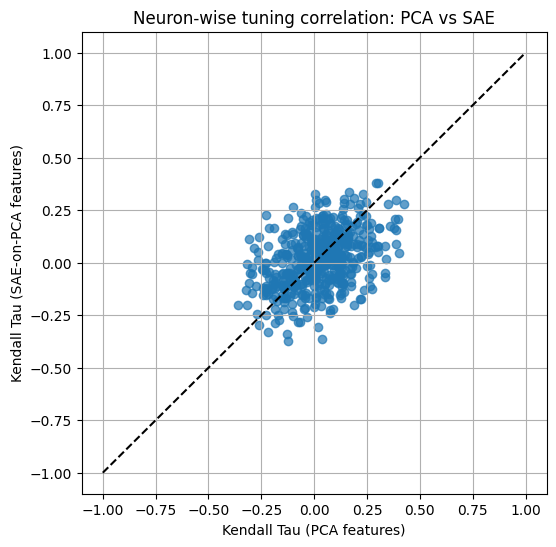


Correlation between PCA and SAE Kendall Taus: r = 0.413


In [1]:
# ================================================================
#  PCA + Sparse Autoencoder (SAE-on-PCA) Neural Predictivity Analysis
#     — using Kendall Tau rank alignment instead of AUC
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import pickle, warnings, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore", category=ConvergenceWarning)
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Merge-sort Kendall Tau implementation
# ---------------------------------------------------------------
def merge_and_count(left, right):
    i = j = inv = 0
    merged = np.empty(len(left) + len(right), dtype=float)
    k = 0
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            merged[k] = left[i]; i += 1
        else:
            merged[k] = right[j]; j += 1
            inv += len(left) - i
        k += 1
    if i < len(left):
        merged[k:] = left[i:]
    if j < len(right):
        merged[k:] = right[j:]
    return merged, inv

def inversion_merge_sort(arr):
    n = len(arr)
    if n <= 1:
        return arr, 0
    mid = n // 2
    left, inv_left = inversion_merge_sort(arr[:mid])
    right, inv_right = inversion_merge_sort(arr[mid:])
    merged, inv_split = merge_and_count(left, right)
    return merged, inv_left + inv_right + inv_split

def kendall_tau_rank(y, p):
    """Compute Kendall tau via inversion counting (O(n log n))."""
    order = np.argsort(y)
    p_sorted = np.asarray(p)[order]
    n = len(p_sorted)
    _, n_inv = inversion_merge_sort(p_sorted)
    total_pairs = n * (n - 1) / 2
    I = n_inv / total_pairs
    tau = 1 - 2 * I
    return tau

# ---------------------------------------------------------------
#  Helper: Fisher information
# ---------------------------------------------------------------
def fisher_information_from_logreg(model, X):
    p = model.predict_proba(X)[:, 1]
    W = np.diag(p * (1 - p))
    return X.T @ W @ X / len(X)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load('/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy')
print("dat shape (neurons x trials):", dat.shape)

path = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
with open(path, 'rb') as f:
    vit_dict = pickle.load(f)['natural_scenes']

embeddings = np.stack(list(vit_dict))          # (118, 1000)
X = softmax(embeddings, axis=1)

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)
test_img_ids = np.repeat(np.arange(n_images), n_trials)[test_mask]

# ---------------------------------------------------------------
#  CLR transform
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  PCA pipeline
# ================================================================
print("\n=== Running PCA pipeline ===")
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} components explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

plt.figure(figsize=(6,4))
plt.plot(cum_var*100)
plt.axhline(90, color='r', linestyle='--')
plt.xlabel('Components')
plt.ylabel('Cumulative variance explained (%)')
plt.title(f'PCA variance curve ({n_components_90} comps)')
plt.grid(True)
plt.show()

# ---------------------------------------------------------------
#  Logistic regressions per neuron (PCA features)
# ---------------------------------------------------------------
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results_pca = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(X_train_pca, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(X_test_pca)[:, 1]

    # --- Compute image-level averages ---
    df = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob})
    agg = df.groupby("img").agg(y_mean=("y", "mean"), p_mean=("p", "mean")).reset_index()

    tau = kendall_tau_rank(agg["y_mean"].to_numpy(), agg["p_mean"].to_numpy())

    I = fisher_information_from_logreg(model, X_train_pca)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    results_pca.append({
        "neuron_idx": idx, "KendallTau": tau,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w
    })

df_pca = pd.DataFrame(results_pca)
print(f"PCA: computed Kendall Tau for {len(df_pca)} neurons")

# ================================================================
#  SAE trained on PCA features (monosemantic expansion)
# ================================================================
print("\n=== Training SAE on PCA features (monosemantic expansion) ===")

SAE_DIM = 100
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad()
            loss.backward()
            opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

# Train SAE on PCA features
sae_model, sae_scaler = train_sae(X_train_pca)
Z_train = encode(sae_model, sae_scaler, X_train_pca)
Z_test  = encode(sae_model, sae_scaler, X_test_pca)
print(f"SAE latent shapes: train {Z_train.shape}, test {Z_test.shape}")

# ---------------------------------------------------------------
#  Logistic regressions per neuron (SAE features)
# ---------------------------------------------------------------
results_sae = []
for idx in sampled_neurons:
    y = Y_binary[idx]
    y_train, y_test = y[train_mask], y[test_mask]

    model = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='liblinear')
    try:
        model.fit(Z_train, y_train)
    except Exception:
        continue

    y_prob = model.predict_proba(Z_test)[:, 1]

    df = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob})
    agg = df.groupby("img").agg(y_mean=("y", "mean"), p_mean=("p", "mean")).reset_index()

    tau = kendall_tau_rank(agg["y_mean"].to_numpy(), agg["p_mean"].to_numpy())

    I = fisher_information_from_logreg(model, Z_train)
    w = model.coef_.ravel()
    FI_trace, FI_along_w = np.trace(I), float(w @ I @ w)
    results_sae.append({
        "neuron_idx": idx, "KendallTau": tau,
        "FI_trace": FI_trace, "FI_along_w": FI_along_w
    })

df_sae = pd.DataFrame(results_sae)
print(f"SAE: computed Kendall Tau for {len(df_sae)} neurons")

# ================================================================
#  Compare PCA vs SAE
# ================================================================
merged = pd.merge(df_pca[["neuron_idx","KendallTau","FI_along_w"]],
                  df_sae[["neuron_idx","KendallTau","FI_along_w"]],
                  on="neuron_idx", suffixes=("_PCA","_SAE"))

plt.figure(figsize=(6,6))
plt.scatter(merged["KendallTau_PCA"], merged["KendallTau_SAE"], alpha=0.7)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Kendall Tau (PCA features)")
plt.ylabel("Kendall Tau (SAE-on-PCA features)")
plt.title("Neuron-wise tuning correlation: PCA vs SAE")
plt.grid(True)
plt.show()

r = np.corrcoef(merged["KendallTau_PCA"], merged["KendallTau_SAE"])[0,1]
print(f"\nCorrelation between PCA and SAE Kendall Taus: r = {r:.3f}")


Using device: cuda
dat shape (neurons × trials): (39209, 5900)
PCA: 15 comps explain ≥90% variance

Training SAE...
Epoch  10/60 | loss=0.000948
Epoch  20/60 | loss=0.001288
Epoch  30/60 | loss=0.000709
Epoch  40/60 | loss=0.000624
Epoch  50/60 | loss=0.000559
Epoch  60/60 | loss=0.000550
SAE latent: (4500, 100) (1400, 100)

Model-selection summary:
selection
INCONCL    475
PCA         14
SAE         11
Name: count, dtype: int64

Significant neurons after FDR=0.05: 0 / 500


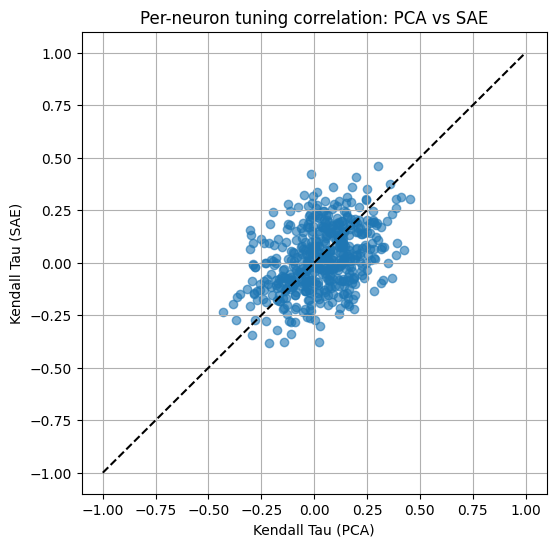

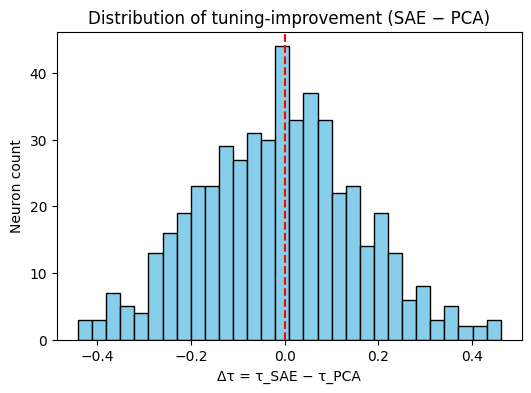


Top neurons preferring SAE:
     neuron_idx   tau_PCA   tau_SAE  delta_tau   boot_lo   boot_hi     p_adj
433       24711 -0.303813  0.157749   0.461562  0.042939  0.816863  0.985965
324       28019 -0.196862  0.242511   0.439373  0.000000  0.840068  0.985965
113       17490 -0.013171  0.421472   0.434643 -0.047775  0.875011  0.985965
18         7070 -0.300126  0.130243   0.430369  0.159621  0.717473  0.985965
155        3454 -0.125562  0.281019   0.406581  0.134716  0.700219  0.985965
486        7681 -0.209018  0.184428   0.393446 -0.000171  0.726532  0.985965
217       27409 -0.290175  0.092173   0.382348  0.028343  0.733193  0.985965
387       21177 -0.304183  0.066127   0.370309  0.073047  0.681159  0.985965
152       30922 -0.049357  0.320823   0.370180  0.043473  0.678764  0.985965
75        37867 -0.251457  0.114299   0.365756  0.077114  0.690043  0.985965


In [3]:
# ================================================================
#  Per-Neuron Model Selection: PCA vs SAE (Kendall Tau criterion)
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skbio.stats.composition import clr
from scipy.special import softmax
from scipy.stats import kendalltau
from statsmodels.stats.multitest import multipletests
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

# ---------------------------------------------------------------
#  Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
#  Helper: Kendall Tau utilities
# ---------------------------------------------------------------
def kendall_tau_b(y_mean, p_mean):
    tau, _ = kendalltau(y_mean, p_mean, nan_policy="omit")
    return float(tau)

def paired_boot_ci_delta_tau(y_mean, p_pca, p_sae, B=2000, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_mean)
    idx = np.arange(n)
    deltas = []
    for _ in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        tau_p = kendall_tau_b(y_mean[samp], p_pca[samp])
        tau_s = kendall_tau_b(y_mean[samp], p_sae[samp])
        deltas.append(tau_s - tau_p)
    deltas = np.array(deltas)
    return float(np.mean(deltas)), float(np.quantile(deltas, 0.025)), float(np.quantile(deltas, 0.975))

def paired_perm_p_delta_tau(y_mean, p_pca, p_sae, R=2000, seed=0):
    rng = np.random.default_rng(seed)
    obs = kendall_tau_b(y_mean, p_sae) - kendall_tau_b(y_mean, p_pca)
    n = len(y_mean)
    count = 0
    for _ in range(R):
        mask = rng.random(n) < 0.5
        p1 = np.where(mask, p_sae, p_pca)
        p2 = np.where(mask, p_pca, p_sae)
        stat = kendall_tau_b(y_mean, p1) - kendall_tau_b(y_mean, p2)
        if stat >= obs:
            count += 1
    pval = (count + 1) / (R + 1)
    return float(obs), float(pval)

# ---------------------------------------------------------------
#  Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)

# ---------------------------------------------------------------
#  Trial structure
# ---------------------------------------------------------------
n_neurons, n_samples = dat.shape
n_images = 118
n_trials = 50
assert n_samples == n_images * n_trials

img_indices = np.arange(n_images)
img_train, img_test = train_test_split(img_indices, test_size=28, random_state=42)
train_mask = np.isin(np.repeat(np.arange(n_images), n_trials), img_train)
test_mask  = np.isin(np.repeat(np.arange(n_images), n_trials), img_test)
test_img_ids = np.repeat(np.arange(n_images), n_trials)[test_mask]

# ---------------------------------------------------------------
#  Transform
# ---------------------------------------------------------------
Y_binary = (dat > 0).astype(int)
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

# ================================================================
#  PCA Features
# ================================================================
pca_full = PCA()
pca_full.fit(X_trials_clr[test_mask])
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} comps explain ≥90% variance")

pca = PCA(n_components=n_components_90)
pca.fit(X_trials_clr[train_mask])
X_train_pca = pca.transform(X_trials_clr[train_mask])
X_test_pca  = pca.transform(X_trials_clr[test_mask])

# ================================================================
#  SAE on PCA features
# ================================================================
SAE_DIM = 100
SAE_EPOCHS = 60
SAE_BATCH = 256
SAE_LR = 1e-3
SAE_L1 = 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(),
            nn.Linear(500, d_latent), nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS,
              batch=SAE_BATCH, lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE...")
sae_model, sae_scaler = train_sae(X_train_pca)
Z_train = encode(sae_model, sae_scaler, X_train_pca)
Z_test  = encode(sae_model, sae_scaler, X_test_pca)
print("SAE latent:", Z_train.shape, Z_test.shape)

# ================================================================
#  Logistic + Kendall Tau per neuron
# ================================================================
sampled_neurons = rng.choice(np.arange(n_neurons), size=500, replace=False)
results = []

for idx in sampled_neurons:
    y = Y_binary[idx]
    y_train, y_test = y[train_mask], y[test_mask]

    # --- PCA model ---
    log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_pca.fit(X_train_pca, y_train)
    except Exception:
        continue
    y_prob_pca = log_pca.predict_proba(X_test_pca)[:, 1]

    # --- SAE model ---
    log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
    try:
        log_sae.fit(Z_train, y_train)
    except Exception:
        continue
    y_prob_sae = log_sae.predict_proba(Z_test)[:, 1]

    # --- aggregate by image ---
    dfp = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_pca})
    dfs = pd.DataFrame({"img": test_img_ids, "y": y_test, "p": y_prob_sae})
    agg_p = dfp.groupby("img").agg(y_mean=("y","mean"), p_mean=("p","mean"))
    agg_s = dfs.groupby("img").agg(y_mean=("y","mean"), p_mean=("p","mean"))

    y_img = agg_p["y_mean"].to_numpy()
    p_img_pca = agg_p["p_mean"].to_numpy()
    p_img_sae = agg_s["p_mean"].to_numpy()

    tau_p = kendall_tau_b(y_img, p_img_pca)
    tau_s = kendall_tau_b(y_img, p_img_sae)
    delta_mean, lo, hi = paired_boot_ci_delta_tau(y_img, p_img_pca, p_img_sae, B=1000, seed=idx)
    obs, p_perm = paired_perm_p_delta_tau(y_img, p_img_pca, p_img_sae, R=2000, seed=idx)
    select = "SAE" if lo > 0 else ("PCA" if hi < 0 else "INCONCL")

    results.append({
        "neuron_idx": idx,
        "tau_PCA": tau_p, "tau_SAE": tau_s,
        "delta_tau": obs,
        "boot_mean": delta_mean, "boot_lo": lo, "boot_hi": hi,
        "p_perm": p_perm, "selection": select
    })

df = pd.DataFrame(results)
reject, pvals_corrected, _, _ = multipletests(df["p_perm"], alpha=0.05, method="fdr_bh")
df["p_adj"], df["significant"] = pvals_corrected, reject

print("\nModel-selection summary:")
print(df["selection"].value_counts())
print(f"\nSignificant neurons after FDR=0.05: {df['significant'].sum()} / {len(df)}")

# ================================================================
#  Visualization
# ================================================================
plt.figure(figsize=(6,6))
plt.scatter(df["tau_PCA"], df["tau_SAE"], alpha=0.6)
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel("Kendall Tau (PCA)")
plt.ylabel("Kendall Tau (SAE)")
plt.title("Per-neuron tuning correlation: PCA vs SAE")
plt.grid(True)
plt.show()

# Δτ histogram
plt.figure(figsize=(6,4))
plt.hist(df["delta_tau"], bins=30, color="skyblue", edgecolor="k")
plt.axvline(0, color="r", linestyle="--")
plt.xlabel("Δτ = τ_SAE − τ_PCA")
plt.ylabel("Neuron count")
plt.title("Distribution of tuning-improvement (SAE − PCA)")
plt.show()

# Top improved neurons
print("\nTop neurons preferring SAE:")
print(df.sort_values("delta_tau", ascending=False).head(10)[["neuron_idx","tau_PCA","tau_SAE","delta_tau","boot_lo","boot_hi","p_adj"]])


In [5]:
# ================================================================
#  Top neurons preferring PCA over SAE
# ================================================================

# Keep only neurons where PCA > SAE
pca_pref = df[df["delta_tau"] < 0].copy()

# Sort by magnitude of improvement in favor of PCA
pca_pref["improvement"] = -pca_pref["delta_tau"]
top_pca = (
    pca_pref.sort_values("improvement", ascending=False)
            .head(10)[["neuron_idx","tau_PCA","tau_SAE","delta_tau","boot_lo","boot_hi","p_adj"]]
)

print("\nTop neurons preferring PCA:")
print(top_pca.to_string(index=False))



Top neurons preferring PCA:
 neuron_idx  tau_PCA   tau_SAE  delta_tau   boot_lo   boot_hi    p_adj
        386 0.369462 -0.071687  -0.441148 -0.789378 -0.118744 0.994993
      24940 0.284208 -0.134927  -0.419135 -0.792993 -0.101879 0.990936
      28489 0.318276 -0.098376  -0.416652 -0.769858 -0.059584 0.990936
       7800 0.186618 -0.222738  -0.409356 -0.687679 -0.138255 0.994993
      10412 0.324400 -0.081100  -0.405500 -0.666926 -0.182135 0.994993
      26513 0.024922 -0.379372  -0.404294 -0.790997  0.005729 0.989851
      15930 0.163098 -0.205383  -0.368481 -0.769492  0.073377 0.985965
      25807 0.425960  0.059994  -0.365966 -0.703900 -0.038693 0.989851
      27783 0.119583 -0.245144  -0.364727 -0.681030 -0.067529 0.989851
      16929 0.184595 -0.173058  -0.357653 -0.666398 -0.071727 0.989851


Using device: cuda
dat shape (neurons × trials): (39209, 5900)
PCA: 44 comps explain ≥90% variance.

Training SAE on PCA features (all images)...
Epoch  10/60 | loss=0.001177
Epoch  20/60 | loss=0.001508
Epoch  30/60 | loss=0.001051
Epoch  40/60 | loss=0.000928
Epoch  50/60 | loss=0.001073
Epoch  60/60 | loss=0.000817
SAE latent shape: (5900, 100)

=== 5-Fold Crossvalidated Kendall τ (PCA-preferring neurons) ===
   neuron_idx  tau_PCA_mean  tau_PCA_std  tau_SAE_mean  tau_SAE_std  \
0         386        0.1769       0.0949       -0.0543       0.1054   
1       24940        0.0456       0.1200        0.0672       0.0895   
2       28489        0.1328       0.1380        0.0256       0.1369   
3        7800        0.0944       0.0959        0.0736       0.1722   
4       10412        0.1710       0.0983        0.0995       0.2398   
5       26513        0.0850       0.1980        0.0070       0.2158   
6       15930        0.0611       0.1288        0.1131       0.0829   
7       25807   

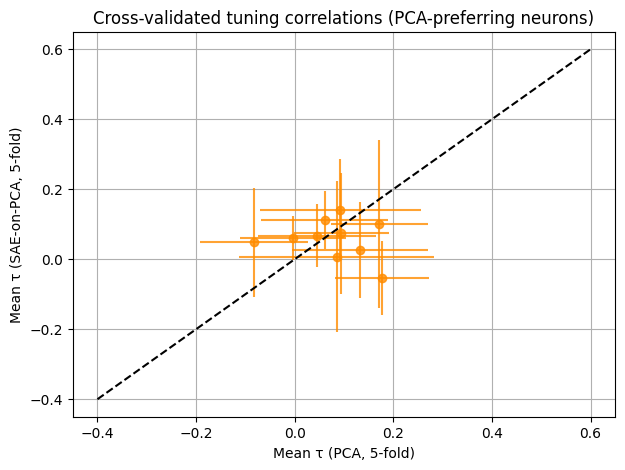

In [ ]:
# ================================================================
# 5-FOLD CROSSVALIDATION: Verify PCA-preferring neurons
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from skbio.stats.composition import clr
from scipy.stats import kendalltau
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

# ---------------------------------------------------------------
# Setup
# ---------------------------------------------------------------
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)

n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
assert n_samples == n_images * n_trials
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# CLR transform and PCA
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
X_trials_clr = np.repeat(X_clr, n_trials, axis=0)

pca_full = PCA()
pca_full.fit(X_trials_clr)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cum_var >= 0.90) + 1
print(f"PCA: {n_components_90} comps explain ≥90% variance.")

pca = PCA(n_components=n_components_90)
X_pca_full = pca.fit_transform(X_trials_clr)

# ---------------------------------------------------------------
# SAE trained on PCA features
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1, device=DEVICE):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(device)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 10 == 0 or ep == epochs:
            print(f"Epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

print("\nTraining SAE on PCA features (all images)...")
sae_model, sae_scaler = train_sae(X_pca_full)
Z_full = encode(sae_model, sae_scaler, X_pca_full)
print(f"SAE latent shape: {Z_full.shape}")

# ---------------------------------------------------------------
# Helper: Kendall Tau per-image
# ---------------------------------------------------------------
def compute_tau(y_true, y_pred, img_ids):
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    tau, _ = kendalltau(agg["y"], agg["p"], nan_policy="omit")
    return tau

# ================================================================
# Crossvalidation on PCA-preferring neurons
# ================================================================
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(n_images)))

for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    tau_pca_folds, tau_sae_folds = [], []

    for train_img_idx, test_img_idx in folds:
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full, test_img_idx)
        Xp_train, Xp_test = X_pca_full[train_mask], X_pca_full[test_mask]
        Z_train, Z_test   = Z_full[train_mask], Z_full[test_mask]
        y_train, y_test   = y_all[train_mask], y_all[test_mask]
        test_img_ids      = img_ids_full[test_mask]

        # PCA logistic
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(Xp_train, y_train)
        y_pred_pca = log_pca.predict_proba(Xp_test)[:, 1]
        tau_pca = compute_tau(y_test, y_pred_pca, test_img_ids)
        tau_pca_folds.append(tau_pca)

        # SAE logistic
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        tau_sae = compute_tau(y_test, y_pred_sae, test_img_ids)
        tau_sae_folds.append(tau_sae)

    records.append({
        "neuron_idx": nid,
        "tau_PCA_mean": np.nanmean(tau_pca_folds),
        "tau_PCA_std": np.nanstd(tau_pca_folds),
        "tau_SAE_mean": np.nanmean(tau_sae_folds),
        "tau_SAE_std": np.nanstd(tau_sae_folds),
        "delta_tau_mean": np.nanmean(np.array(tau_sae_folds) - np.array(tau_pca_folds))
    })

df_cv_pca = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Kendall τ (PCA-preferring neurons) ===")
print(df_cv_pca.round(4))

# ---------------------------------------------------------------
# Visualization
# ---------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.errorbar(df_cv_pca["tau_PCA_mean"], df_cv_pca["tau_SAE_mean"],
             xerr=df_cv_pca["tau_PCA_std"], yerr=df_cv_pca["tau_SAE_std"],
             fmt='o', alpha=0.8, color='darkorange')
plt.plot([-0.4,0.6],[-0.4,0.6],'k--')
plt.xlabel("Mean τ (PCA, 5-fold)")
plt.ylabel("Mean τ (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated tuning correlations (PCA-preferring neurons)")
plt.grid(True)
plt.show()


Using device: cuda
dat shape (neurons × trials): (39209, 5900)

Neuron 386 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.329317
SAE epoch  40/60 | loss=0.022536
SAE epoch  60/60 | loss=0.004920

 Fold 2/5
SAE epoch  20/60 | loss=0.338762
SAE epoch  40/60 | loss=0.024764
SAE epoch  60/60 | loss=0.004854

 Fold 3/5
SAE epoch  20/60 | loss=0.345944
SAE epoch  40/60 | loss=0.023205
SAE epoch  60/60 | loss=0.004639

 Fold 4/5
SAE epoch  20/60 | loss=0.336366
SAE epoch  40/60 | loss=0.025424
SAE epoch  60/60 | loss=0.005003

 Fold 5/5
SAE epoch  20/60 | loss=0.343840
SAE epoch  40/60 | loss=0.024978
SAE epoch  60/60 | loss=0.004768

Neuron 24940 -------------------------

 Fold 1/5
SAE epoch  20/60 | loss=0.327544
SAE epoch  40/60 | loss=0.023059
SAE epoch  60/60 | loss=0.004737

 Fold 2/5
SAE epoch  20/60 | loss=0.341422
SAE epoch  40/60 | loss=0.024155
SAE epoch  60/60 | loss=0.004940

 Fold 3/5
SAE epoch  20/60 | loss=0.325379
SAE epoch  40/60 | loss=0.024454
SAE epoch  6

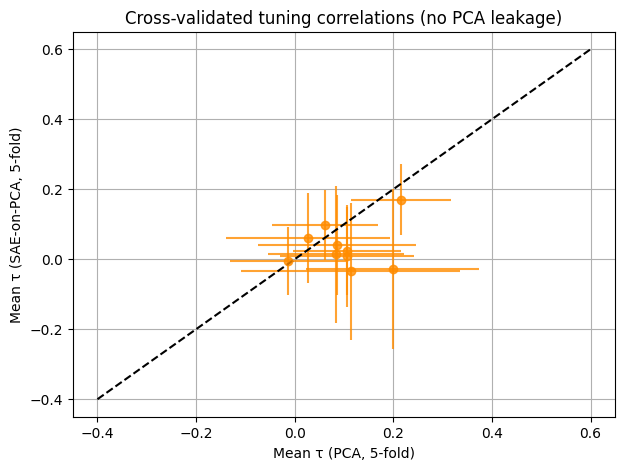

In [3]:
# ================================================================
# 5-FOLD CROSSVALIDATION (NO PCA LEAKAGE)
# ================================================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from skbio.stats.composition import clr
from scipy.stats import kendalltau
from scipy.special import softmax
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings, pickle

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)
torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ---------------------------------------------------------------
# Load data
# ---------------------------------------------------------------
dat = np.load("/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy")
print("dat shape (neurons × trials):", dat.shape)

path = "/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl"
with open(path, "rb") as f:
    vit_dict = pickle.load(f)["natural_scenes"]

embeddings = np.stack(list(vit_dict))   # (118, 1000)
X = softmax(embeddings, axis=1)
Y_binary = (dat > 0).astype(int)
n_neurons, n_samples = dat.shape
n_images, n_trials = 118, 50
img_ids_full = np.repeat(np.arange(n_images), n_trials)

# ---------------------------------------------------------------
# SAE definition
# ---------------------------------------------------------------
SAE_DIM, SAE_EPOCHS, SAE_BATCH, SAE_LR, SAE_L1 = 100, 60, 256, 1e-3, 1e-3

class SAE(nn.Module):
    def __init__(self, d_in, d_latent):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(d_in, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_latent), nn.ReLU(inplace=True)
        )
        self.dec = nn.Sequential(
            nn.Linear(d_latent, 500), nn.ReLU(inplace=True),
            nn.Linear(500, d_in)
        )
    def forward(self, x):
        h = self.enc(x)
        return self.dec(h), h

def train_sae(X_train, d_latent=SAE_DIM, epochs=SAE_EPOCHS, batch=SAE_BATCH,
              lr=SAE_LR, l1=SAE_L1):
    d_in = X_train.shape[1]
    model = SAE(d_in, d_latent).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    scaler = StandardScaler().fit(X_train)
    X_std = scaler.transform(X_train)
    dl = DataLoader(TensorDataset(torch.from_numpy(X_std.astype(np.float32))),
                    batch_size=batch, shuffle=True)
    for ep in range(1, epochs+1):
        tot = 0
        for (xb,) in dl:
            xb = xb.to(DEVICE)
            x_hat, h = model(xb)
            loss = mse(x_hat, xb) + l1 * torch.mean(torch.abs(h))
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if ep % 20 == 0 or ep == epochs:
            print(f"SAE epoch {ep:3d}/{epochs} | loss={tot/len(dl.dataset):.6f}")
    return model, scaler

@torch.no_grad()
def encode(model, scaler, X):
    X_std = scaler.transform(X)
    xb = torch.from_numpy(X_std.astype(np.float32)).to(DEVICE)
    _, h = model(xb)
    return h.cpu().numpy()

def compute_tau(y_true, y_pred, img_ids):
    df = pd.DataFrame({"img": img_ids, "y": y_true, "p": y_pred})
    agg = df.groupby("img").mean()
    tau, _ = kendalltau(agg["y"], agg["p"], nan_policy="omit")
    return tau

# ---------------------------------------------------------------
# Prepare folds and neurons
# ---------------------------------------------------------------
X_clr = clr(X + 1e-12)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
top_pca_neurons = [386, 24940, 28489, 7800, 10412, 26513, 15930, 25807, 27783, 16929]
records = []

# ---------------------------------------------------------------
# Cross-validation with fold-wise PCA and SAE training
# ---------------------------------------------------------------
for nid in top_pca_neurons:
    y_all = Y_binary[nid]
    tau_pca_folds, tau_sae_folds = [], []

    print(f"\nNeuron {nid} -------------------------")

    for fold_i, (train_img_idx, test_img_idx) in enumerate(kf.split(np.arange(n_images)), 1):
        print(f"\n Fold {fold_i}/5")

        # PCA trained only on training images
        pca_train = PCA()
        pca_train.fit(X_clr[train_img_idx])
        cum_var = np.cumsum(pca_train.explained_variance_ratio_)
        n_components_90 = np.argmax(cum_var >= 0.90) + 1
        pca = PCA(n_components=n_components_90)
        X_train_pca_unique = pca.fit_transform(X_clr[train_img_idx])
        X_test_pca_unique  = pca.transform(X_clr[test_img_idx])

        # Repeat to trials
        X_train_pca = np.repeat(X_train_pca_unique, n_trials, axis=0)
        X_test_pca  = np.repeat(X_test_pca_unique, n_trials, axis=0)
        train_mask = np.isin(img_ids_full, train_img_idx)
        test_mask  = np.isin(img_ids_full, test_img_idx)
        y_train, y_test = y_all[train_mask], y_all[test_mask]
        test_img_ids = img_ids_full[test_mask]

        # Train SAE on PCA(train)
        sae_model, sae_scaler = train_sae(X_train_pca_unique)
        Z_train_unique = encode(sae_model, sae_scaler, X_train_pca_unique)
        Z_test_unique  = encode(sae_model, sae_scaler, X_test_pca_unique)
        Z_train = np.repeat(Z_train_unique, n_trials, axis=0)
        Z_test  = np.repeat(Z_test_unique, n_trials, axis=0)

        # Logistic regression: PCA
        log_pca = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_pca.fit(X_train_pca, y_train)
        y_pred_pca = log_pca.predict_proba(X_test_pca)[:, 1]
        tau_pca = compute_tau(y_test, y_pred_pca, test_img_ids)
        tau_pca_folds.append(tau_pca)

        # Logistic regression: SAE
        log_sae = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
        log_sae.fit(Z_train, y_train)
        y_pred_sae = log_sae.predict_proba(Z_test)[:, 1]
        tau_sae = compute_tau(y_test, y_pred_sae, test_img_ids)
        tau_sae_folds.append(tau_sae)

    records.append({
        "neuron_idx": nid,
        "tau_PCA_mean": np.nanmean(tau_pca_folds),
        "tau_PCA_std": np.nanstd(tau_pca_folds),
        "tau_SAE_mean": np.nanmean(tau_sae_folds),
        "tau_SAE_std": np.nanstd(tau_sae_folds),
        "delta_tau_mean": np.nanmean(np.array(tau_sae_folds) - np.array(tau_pca_folds))
    })

# ---------------------------------------------------------------
# Results
# ---------------------------------------------------------------
df_cv_pca = pd.DataFrame(records)
print("\n=== 5-Fold Crossvalidated Kendall τ (no leakage) ===")
print(df_cv_pca.round(4))

plt.figure(figsize=(7,5))
plt.errorbar(df_cv_pca["tau_PCA_mean"], df_cv_pca["tau_SAE_mean"],
             xerr=df_cv_pca["tau_PCA_std"], yerr=df_cv_pca["tau_SAE_std"],
             fmt='o', alpha=0.8, color='darkorange')
plt.plot([-0.4,0.6],[-0.4,0.6],'k--')
plt.xlabel("Mean τ (PCA, 5-fold)")
plt.ylabel("Mean τ (SAE-on-PCA, 5-fold)")
plt.title("Cross-validated tuning correlations (no PCA leakage)")
plt.grid(True)
plt.show()


In [4]:
print(df_cv_pca)

   neuron_idx  tau_PCA_mean  tau_PCA_std  tau_SAE_mean  tau_SAE_std  \
0         386      0.105866     0.135092      0.008157     0.145966   
1       24940      0.061786     0.107204      0.098875     0.100045   
2       28489      0.105156     0.109519      0.023738     0.125583   
3        7800      0.083630     0.138684      0.014486     0.195838   
4       10412      0.215537     0.102349      0.170308     0.101438   
5       26513      0.198327     0.176005     -0.027630     0.227632   
6       15930      0.085176     0.160406      0.041233     0.142395   
7       25807      0.113794     0.222045     -0.034518     0.195450   
8       27783      0.027088     0.166295      0.061000     0.129585   
9       16929     -0.013855     0.117429     -0.004742     0.098203   

   delta_tau_mean  
0       -0.097709  
1        0.037089  
2       -0.081418  
3       -0.069144  
4       -0.045229  
5       -0.225957  
6       -0.043944  
7       -0.148312  
8        0.033912  
9        0.009113 